In [1]:
import importlib

import data_loading as load
import data_preprocessing as pre
import data_augmentation as aug
import metrics

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import models

## UnetGAN

In [2]:
input_func_list = [
    pre.resize,
    aug.Augment(aug.random_brightness, prob=0.3),
    aug.Augment(aug.random_saturation, prob=0.3),
    pre.normalize_pixels
]
truth_func_list = [
    pre.resize,
    pre.invert, 
    pre.to_grayscale, 
    pre.normalize_pixels
]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=1, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


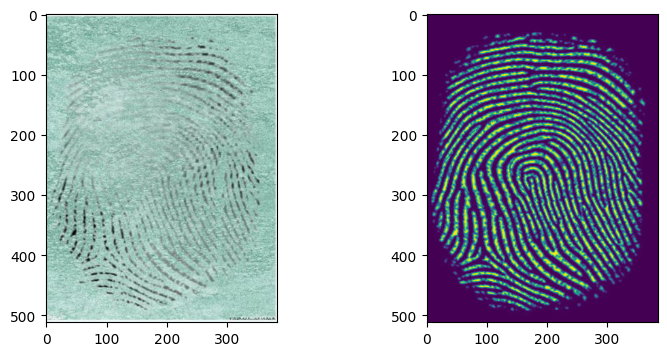

In [3]:
test_input_batch, test_truth_batch = next(test_ds.as_numpy_iterator())
test_input, test_truth = test_input_batch[0], test_truth_batch[0]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(test_input)
axs[1].imshow(test_truth)
plt.show()

In [17]:
importlib.reload(models)
unet_gan = models.UnetGAN(
    tf.keras.optimizers.Adam(0.001), tf.keras.optimizers.Adam(0.001), img_shape=(512, 384, 3)
)

In [18]:
history = unet_gan.fit(train_ds, test_ds, epochs=1, checkpoint_steps=100)

History:
{'gen_total_loss': [], 'gen_gan_loss': [], 'gen_l1_loss': [], 'disc_loss': []}
Epoch: 0


KeyboardInterrupt: 

In [168]:
test_pred = unet_gan.generator(test_input[np.newaxis], training=False)[0]

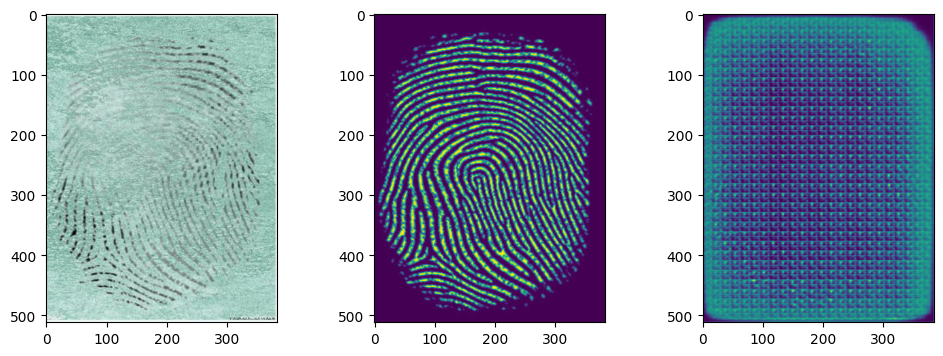

In [169]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(test_input)
axs[1].imshow(test_truth)
axs[2].imshow(test_pred)
plt.show()

## ResNet50 Transfer learning

In [113]:
input_func_list = [
    aug.Augment(aug.random_brightness, prob=0.3),
    aug.Augment(aug.random_saturation, prob=0.3)
]
truth_func_list = [
    pre.invert, 
    pre.to_grayscale
]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [114]:
augments = [
    aug.Augment(aug.horiz_flip_together, prob=0.2), 
    aug.Augment(aug.vert_flip_together, prob=0.2)
]
train_ds = aug.augment_together_dataset(train_ds, augments)

In [115]:
input_batch, truth_batch = next(train_ds.as_numpy_iterator())

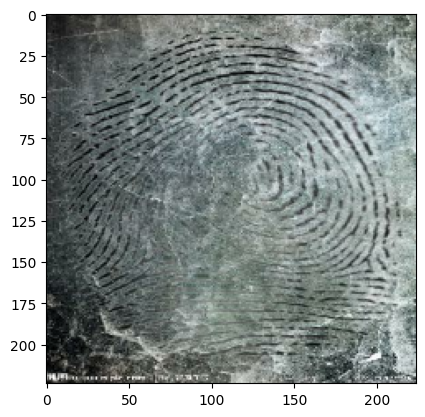

In [126]:
plt.imshow(tf.image.resize(input_batch[3], size=(224, 224)) / 255)

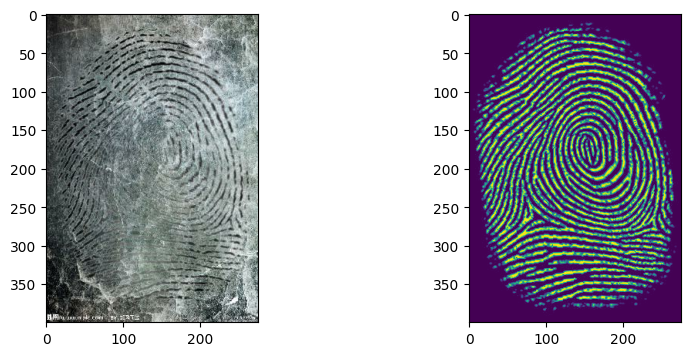

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(input_batch[3].astype(np.uint8))
axs[1].imshow(truth_batch[3].astype(np.uint8))

In [123]:
importlib.reload(models)
resnet_trans = models.get_resnet_transfer()
resnet_trans.compile(
    optimizer="adam",
    loss="mse"
)
resnet_trans.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_52 (Conv2D)          (None, 7, 7, 256)         4718848   
                                                                 
 up_sampling2d_29 (UpSamplin  (None, 21, 21, 256)      0   

In [118]:
history = resnet_trans.fit(train_ds, validation_data=test_ds, epochs=1)

  66/1000 [>.............................] - ETA: 20:50 - loss: 8695.7637

KeyboardInterrupt: 

## Custom model

In [2]:
input_func_list = [
    pre.normalize_pixels
]
truth_func_list = [
    pre.invert, 
    pre.to_grayscale, 
    pre.normalize_pixels
]

ds_factory = load.FingerprintDatasetFactory(input_func_list, truth_func_list, batch_size=4, seed=42)
train_ds = ds_factory("./small_data/training_input", "./small_data/training_truth")
test_ds = ds_factory("./small_data/validation_input", "./small_data/validation_truth")

Found 4000 files belonging to 1 classes.
Found 4000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [24]:
importlib.reload(models)
custom_model = models.get_conv_only(conv_activation="relu")

custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError()
)

custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 400, 301, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 400, 301, 64)      1792      
                                                                 
 average_pooling2d_6 (Averag  (None, 200, 150, 64)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_21 (Conv2D)          (None, 200, 150, 128)     73856     
                                                                 
 average_pooling2d_7 (Averag  (None, 100, 75, 128)     0         
 ePooling2D)                                                     
                                                      

In [25]:
history = custom_model.fit(train_ds, validation_data=test_ds, epochs=3)

Epoch 1/3
  25/1000 [..............................] - ETA: 28:25 - loss: 0.1381

KeyboardInterrupt: 

In [28]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

n_examples = 4
fnames = np.random.choice(filenames, n_examples)
imgs_input = np.array([cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255
imgs_truth = 1 - np.array([cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED) for fname in fnames], dtype=np.float32) / 255

1/1 [==============================] - 0s 347ms/step


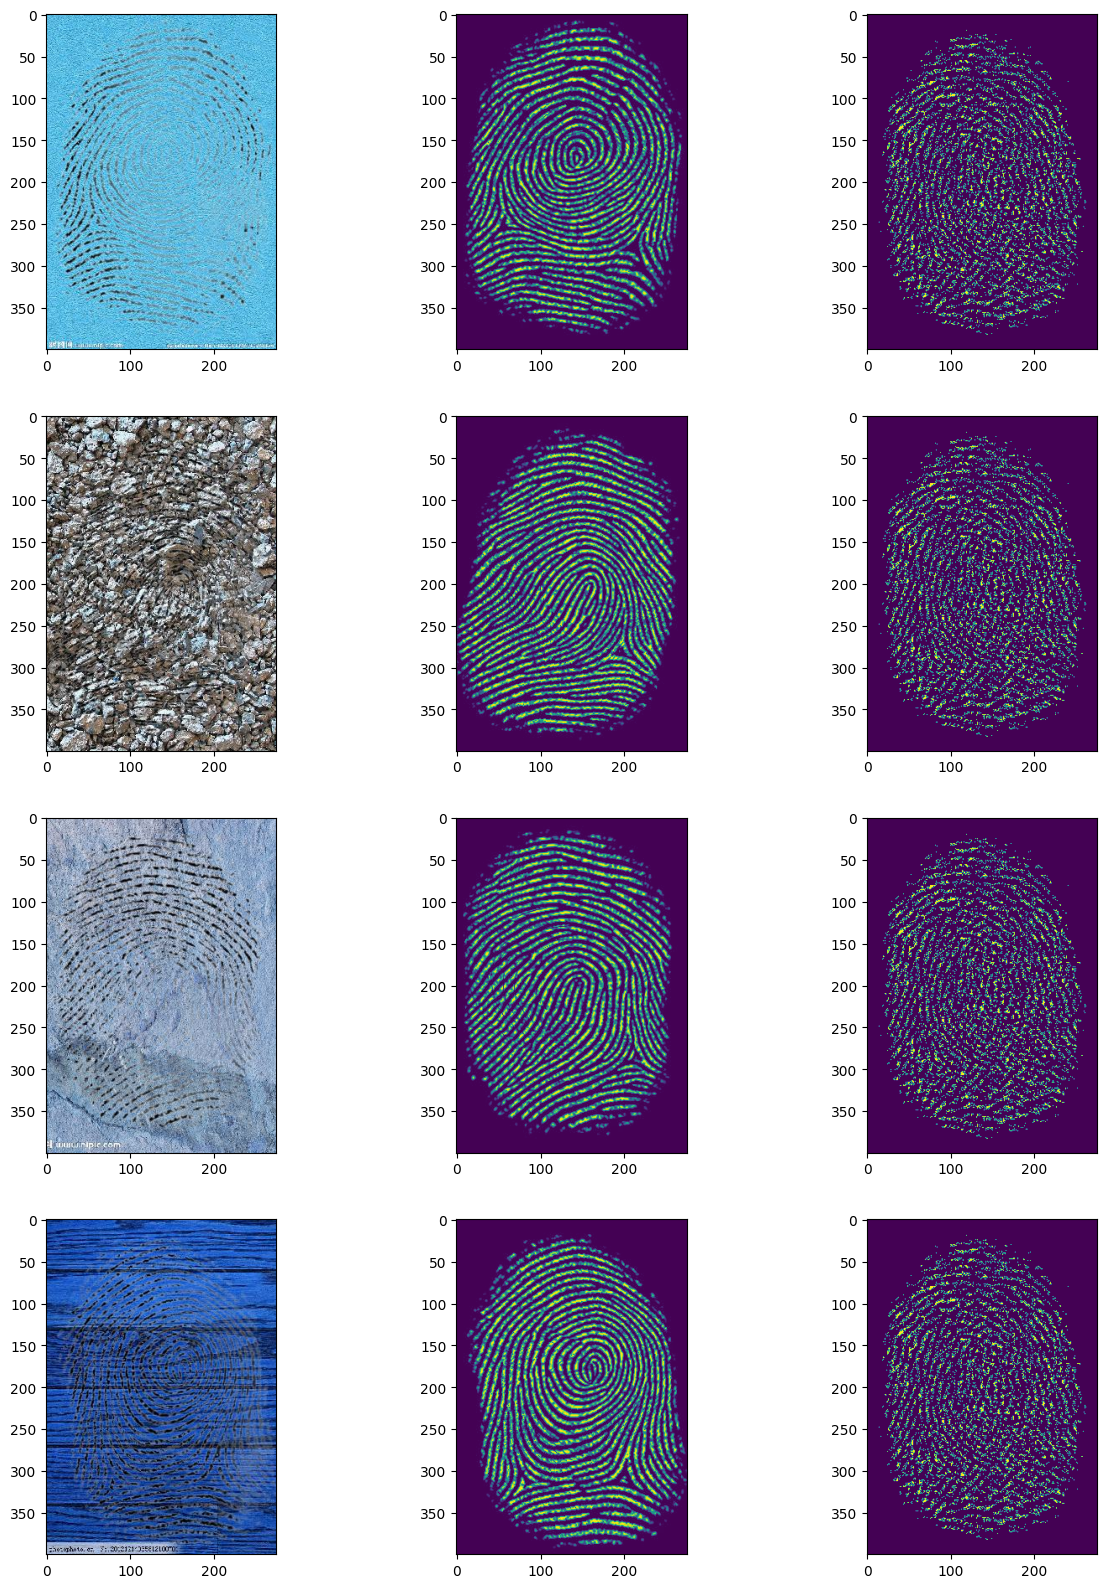

In [15]:
img_predict = custom_model.predict(imgs_input)


fig, axs = plt.subplots(n_examples, 3, figsize=(15, n_examples*5))
for i in range(n_examples):
    axs[i, 0].imshow(imgs_input[i])
    axs[i, 1].imshow(imgs_truth[i])
    axs[i, 2].imshow(img_predict[i])